In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/StockForecasting")

In [ ]:
# All imports
import pickle as pkl
import torch
import pandas as pd

# Loading the data

In [ ]:
with open('training_set.pkl', 'rb') as file:
  train_data = pkl.load(file)

# Understanding the type of data

In [ ]:
type(train_data)

list

In [ ]:
# Type of element inside the list
type(train_data[0])

pandas.core.frame.DataFrame

In [ ]:
# length of the list
len(train_data)

2000

So there are 2000 dataframe objects inside the list.

In [ ]:
train_data[0].shape

(2202, 5)

There are 2202 rows and 5 columns.

In [ ]:
item1 = train_data[0] # Let's examine one consistent item

In [ ]:
item1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

As we can see the columns are named as \
'Open' - Open price of the stock on a day\
'High' - The highest price of the stock on a day\
'Low'  - The lowest price of the stock on a day\
'Close'- The closed price of the stock on a day\
'Volume' - The volume the trade that took place on a day (I presume)

We can understand that there is a data of 2000 stocks. The data of each stock includes Open, High, Low, Close, Volume of consequent 2202 days.

In [ ]:
item1

,Open,High,Low,Close,Volume
0,0.672106,0.679902,0.669265,0.671966,0.336899
1,0.672106,0.674597,0.670546,0.672106,0.208023
2,0.672106,0.678621,0.671827,0.676282,0.142405
3,0.676338,0.677340,0.672384,0.673498,0.146400
4,0.673442,0.676004,0.672997,0.675892,0.116960
...,...,...,...,...,...
2197,0.680849,0.683633,0.672997,0.674055,0.351048
2198,0.674389,0.674890,0.671326,0.674055,0.143069
2199,0.674110,0.676227,0.672440,0.676004,0.312048
2200,0.675725,0.675837,0.668820,0.669321,0.279230


In [ ]:
list1 = [item1['Open'], (item1['High']), item1['Low'], item1['Close'], item1['Volume']]
print([i.dtype for i in list1])

[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


In [ ]:
item1.describe()

,Open,High,Low,Close,Volume
count,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000
mean,0.798608,0.801351,0.795719,0.798501,0.265201
std,0.084629,0.084606,0.084659,0.084655,0.168493
min,0.629894,0.635960,0.626330,0.629337,0.000000
25%,0.732375,0.735062,0.729750,0.732040,0.149827
50%,0.790389,0.793465,0.786323,0.790305,0.217470
75%,0.862547,0.865888,0.858760,0.862324,0.328495
max,0.998719,1.000000,0.997132,0.998663,2.000000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
xaxis = np.linspace(0, 2201, 2202)

In [ ]:
yaxis = item1.iloc[:, 0]

Text(0, 0.5, 'Price (Normalized :( )')

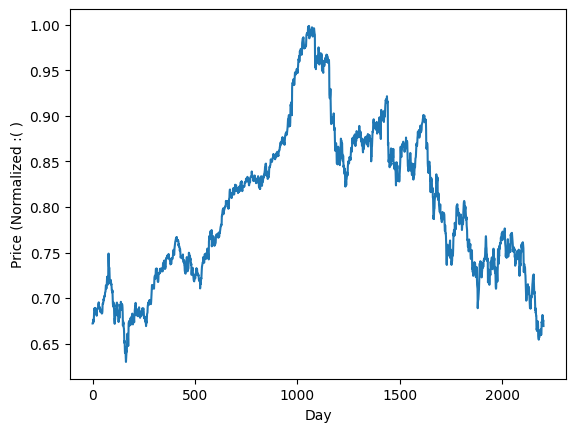

In [ ]:
plt.plot(xaxis, yaxis)
plt.xlabel("Day")
plt.ylabel("Price (Normalized :( )")

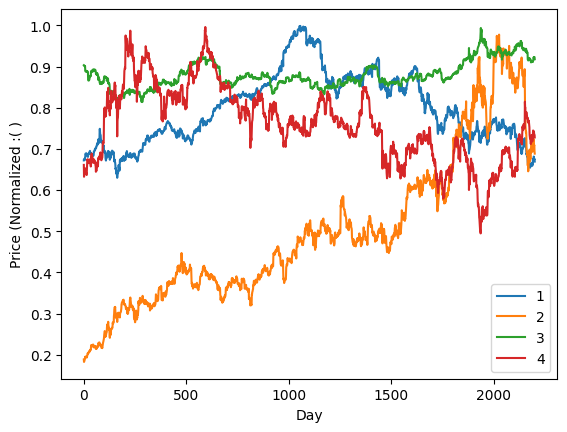

In [ ]:
for i in range(0, 4):
  yaxis = train_data[i].iloc[:, 0]
  plt.plot(xaxis, yaxis, label = f"{i+1}")
plt.xlabel("Day")
plt.ylabel("Price (Normalized :( )")
plt.legend()
plt.show()

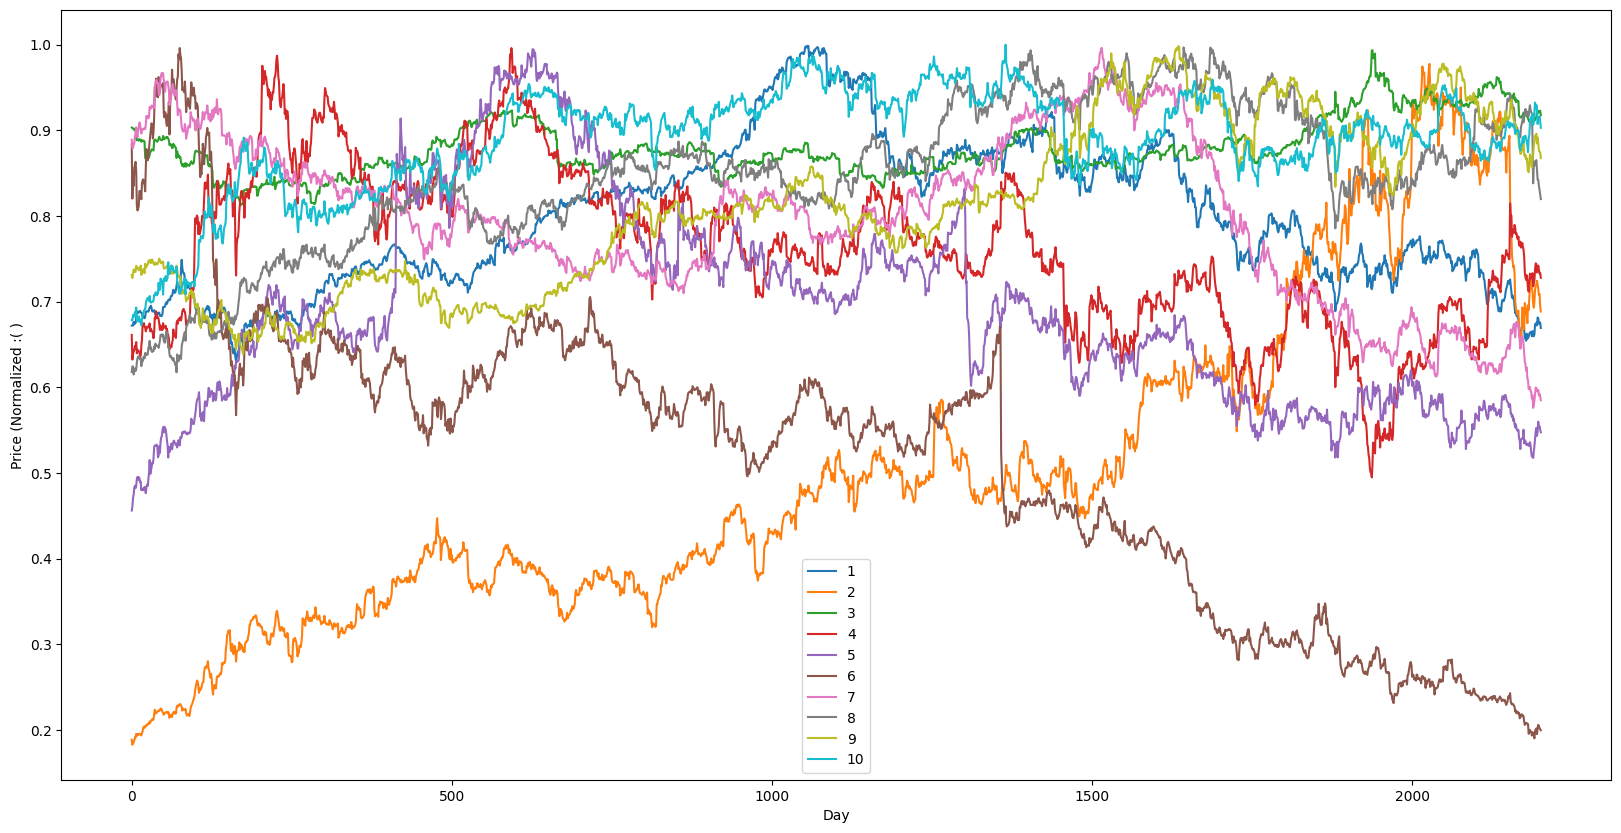

In [ ]:
plt.figure(figsize = (20, 10))
for i in range(0, 10):
  yaxis = train_data[i].iloc[:, 0]
  plt.plot(xaxis, yaxis, label = f"{i+1}")
plt.xlabel("Day")
plt.ylabel("Price (Normalized :( )")
plt.legend()
plt.show()

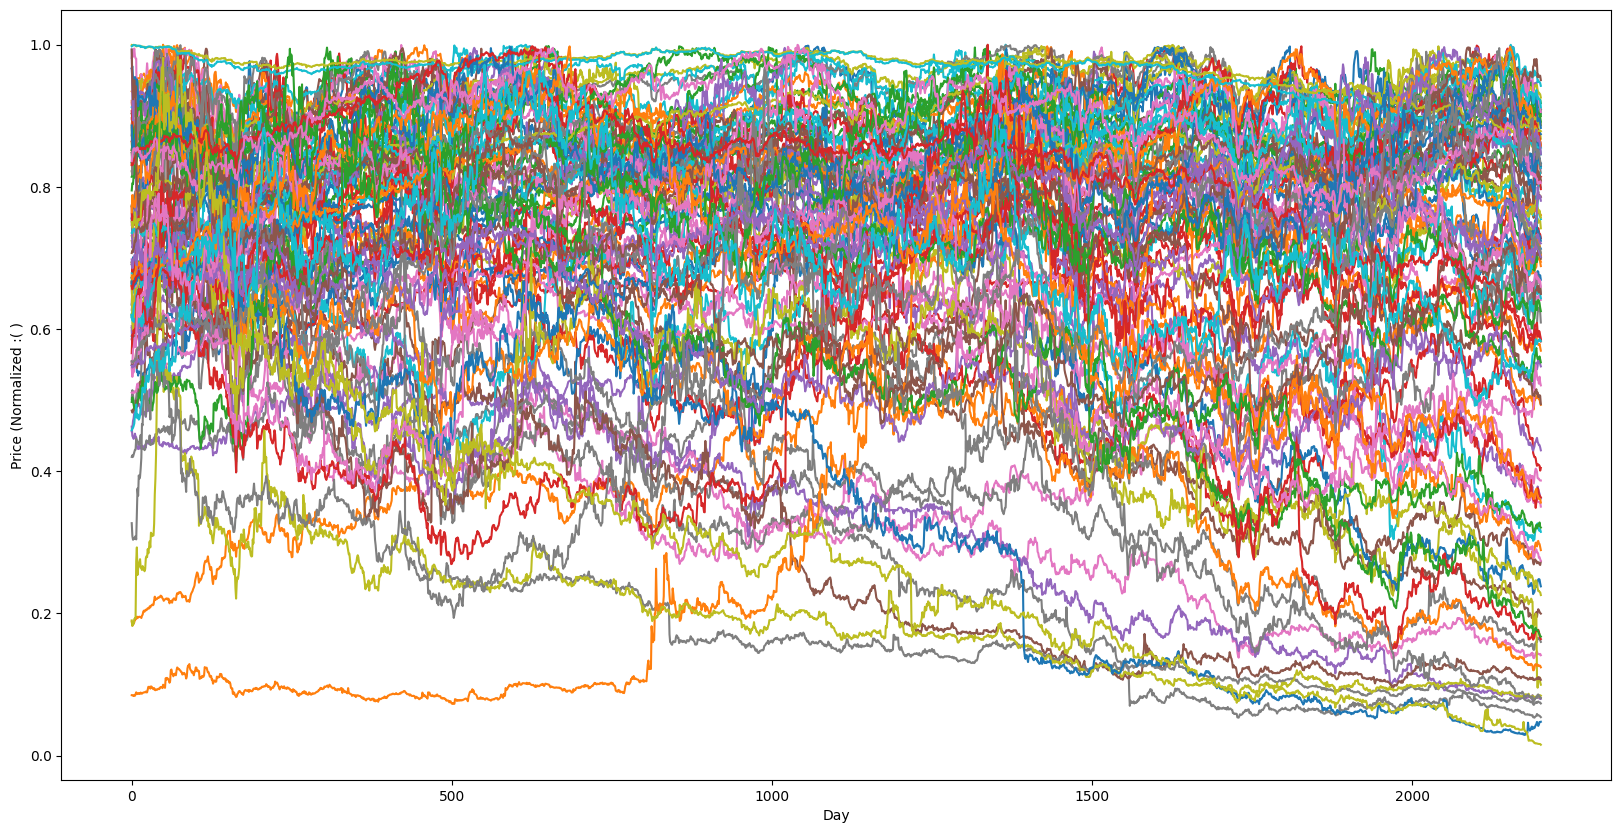

In [ ]:
plt.figure(figsize = (20, 10))
for i in range(0, 100):
  yaxis = train_data[i].iloc[:, 0]
  plt.plot(xaxis, yaxis, label = f"{i+1}")
plt.xlabel("Day")
plt.ylabel("Price (Normalized :( )")
# plt.legend()
plt.show()

Now, let's think about what can we do with this data.\
Predict Open price?\
Predict Close Price?\
Predict Highest price of the day?\
Predict Lowest price of the day?\
Predict trade Volume of the day?

Can we use linear regression to make a prediction?\
How about concatenating stock features of 10 days to predict the 11th day's Close price?\
I will then let linear regression to do its magic.

Preparing the data

Separating labels from features.\
Labels start from index 10 since the first 10 rows of data will be used to determine the close price of row 10 (assume starting from row 0)

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
class StockDataset(Dataset):
  def __init__(self, data, labels, window_size, stride):
    self.data = data
    self.labels = labels
    self.window_size = window_size
    self.stride = stride

  def __len__(self):
    return (len(self.data) - self.window_size)//self.stride

  def __getitem__(self, idx):
    start_idx = idx*self.stride
    end_idx = start_idx + self.window_size
    sample = {'data': self.data[start_idx:end_idx], 'label': self.labels[end_idx]}
    return sample

In [ ]:
data = torch.Tensor(item1.loc[:, ['Open', 'High', 'Low', 'Volume']].values)
labels = torch.Tensor(item1['Close'].values)
window_size = 10
stride = 1

In [ ]:
dataset = StockDataset(data, labels, window_size=window_size, stride=stride)

Verifying if the dataset is as we are expecting or not

In [ ]:
len(dataset)

2192

In [ ]:
dataset[2191]

{'data': tensor([[0.6618, 0.6749, 0.6615, 0.4598],
         [0.6738, 0.6765, 0.6722, 0.3505],
         [0.6727, 0.6770, 0.6724, 0.2858],
         [0.6753, 0.6755, 0.6716, 0.5634],
         [0.6722, 0.6899, 0.6720, 0.4131],
         [0.6815, 0.6820, 0.6782, 0.3625],
         [0.6808, 0.6836, 0.6730, 0.3510],
         [0.6744, 0.6749, 0.6713, 0.1431],
         [0.6741, 0.6762, 0.6724, 0.3120],
         [0.6757, 0.6758, 0.6688, 0.2792]]),
 'label': tensor(0.6642)}

In [ ]:
labels[2201]

tensor(0.6642)

Splitting the dataset into train set and validation set

In [ ]:
train_len = int(0.85*len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

Training a linear model on this dataset

In [ ]:
train_loader = DataLoader(dataset = train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset = val_set, batch_size=1, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
class LinReg(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 1)
    )

  def forward(self, x):
    return self.linear(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
lin_model = LinReg(40)
lin_model.to(device)
optimizer = optim.Adam(lin_model.parameters(), lr=1e-3)
loss_function = nn.functional.mse_loss

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
  lin_model.train()
  for batch in train_loader:
    batch['data'] = batch['data'].to(device)
    batch['label'] = batch['label'].to(device)
    optimizer.zero_grad()
    y_hat = lin_model.forward(batch['data'])
    loss = loss_function(y_hat, batch['label'])
    loss.backward()
    optimizer.step()
  lin_model.eval()
  with torch.no_grad():
    validation_loss = 0
    for batch in val_loader:
      batch['data'] = batch['data'].to(device)
      batch['label'] = batch['label'].to(device)
      y_hat = lin_model.forward(batch['data'])
      y_hat = y_hat.view(-1)
      validation_loss += loss_function(y_hat, batch['label']).item()
  print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {validation_loss / len(val_loader)}")

<ipython-input-34-051cf1d7c927>:9: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_function(y_hat, batch['label'])


Epoch 1/50, Training Loss: 7.728324931122188e-07, Validation Loss: 0.00022791697755835332
Epoch 2/50, Training Loss: 0.00024518294958397746, Validation Loss: 0.00012628361138644157
Epoch 3/50, Training Loss: 0.00012203633377794176, Validation Loss: 9.965890132545747e-05
Epoch 4/50, Training Loss: 7.945291145006195e-05, Validation Loss: 7.30790451844005e-05
Epoch 5/50, Training Loss: 3.068382284254767e-05, Validation Loss: 9.77342302461782e-05
Epoch 6/50, Training Loss: 1.1307854038022924e-05, Validation Loss: 8.01649025628837e-05
Epoch 7/50, Training Loss: 2.7265161406830885e-05, Validation Loss: 7.32179237266554e-05
Epoch 8/50, Training Loss: 0.00027589494129642844, Validation Loss: 0.00011411863338352084
Epoch 9/50, Training Loss: 9.816802958084736e-06, Validation Loss: 5.6939370656936274e-05
Epoch 10/50, Training Loss: 2.5376270059496164e-05, Validation Loss: 8.100150114299893e-05
Epoch 11/50, Training Loss: 0.00022177823120728135, Validation Loss: 6.343843872520907e-05
Epoch 12/50,

In [ ]:
ys = []
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in data_loader:
    batch['data'] = batch['data'].to(device)
    y_hat = lin_model(batch['data'])
    y_hat = y_hat.view(-1)
    y_hat = y_hat.to('cpu')
    y_hat = y_hat.numpy()
    ys.append(y_hat)

In [ ]:
len(ys)

2192

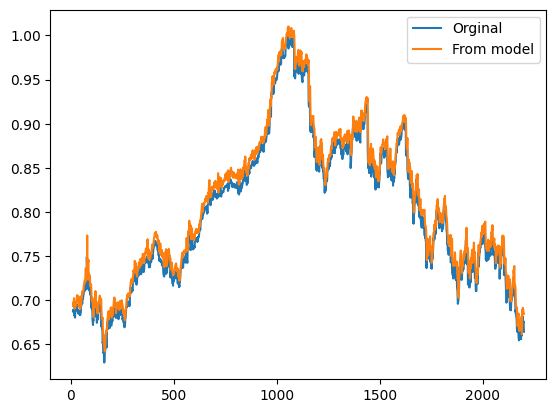

In [ ]:
xaxis = np.linspace(11, 2201, 2192)
yaxis = item1['Close'][10:]
plt.plot(xaxis, yaxis, label='Orginal')
plt.plot(xaxis, ys, label="From model")
plt.legend()

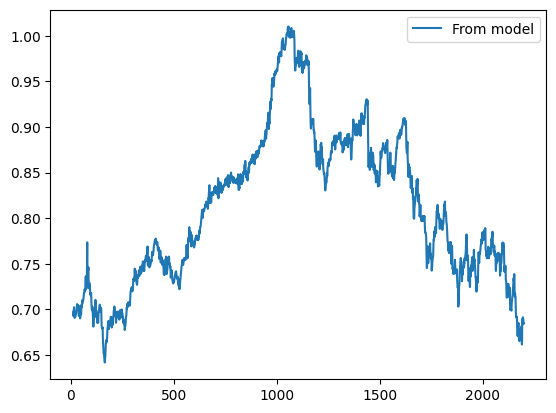

In [ ]:
xaxis = np.linspace(11, 2201, 2192)
plt.plot(xaxis, ys, label="From model")
plt.legend()

Now, I will consider using just Close price. A sequence of Closed price to predict next close price

In [ ]:
data = torch.Tensor(item1.loc[:, ['Close']].values)
labels = torch.Tensor(item1['Close'].values)
window_size = 10
stride = 1

In [ ]:
dataset = StockDataset(data, labels, window_size=window_size, stride=stride)

Just verifying if the dataset is as we expect or not

In [ ]:
len(dataset)

2192

In [ ]:
dataset[2191]

{'data': tensor([[0.6738],
         [0.6728],
         [0.6757],
         [0.6742],
         [0.6813],
         [0.6810],
         [0.6741],
         [0.6741],
         [0.6760],
         [0.6693]]),
 'label': tensor(0.6642)}

In [ ]:
labels[2201]

tensor(0.6642)

Now let's split the dataset into train set and validation set

In [ ]:
train_len = int(0.85*len(dataset))
val_len = len(dataset) - train_len
train_set, val_set = random_split(dataset, [train_len, val_len])

Now lets train a linear model on this dataset

In [ ]:
train_loader = DataLoader(dataset = train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset = val_set, batch_size=1, shuffle=True)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
lin_model = LinReg(10)
lin_model.to(device)
optimizer = optim.Adam(lin_model.parameters(), lr=1e-3)
loss_function = nn.functional.mse_loss

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
  lin_model.train()
  for batch in train_loader:
    batch['data'] = batch['data'].to(device)
    batch['label'] = batch['label'].to(device)
    optimizer.zero_grad()
    y_hat = lin_model.forward(batch['data'])
    loss = loss_function(y_hat, batch['label'])
    loss.backward()
    optimizer.step()
  lin_model.eval()
  with torch.no_grad():
    validation_loss = 0
    for batch in val_loader:
      batch['data'] = batch['data'].to(device)
      batch['label'] = batch['label'].to(device)
      y_hat = lin_model.forward(batch['data'])
      y_hat = y_hat.view(-1)
      validation_loss += loss_function(y_hat, batch['label']).item()
  print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {validation_loss / len(val_loader)}")

<ipython-input-77-fcab08ed1aaa>:9: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_function(y_hat, batch['label'])


Epoch 1/15, Training Loss: 0.00027983941254206, Validation Loss: 4.5377351687569416e-05
Epoch 2/15, Training Loss: 6.051907348592067e-06, Validation Loss: 3.7914513718925475e-05
Epoch 3/15, Training Loss: 1.2004963423351e-07, Validation Loss: 3.106756130052729e-05
Epoch 4/15, Training Loss: 3.6046317291038577e-06, Validation Loss: 2.9498550883992568e-05
Epoch 5/15, Training Loss: 1.82595249498263e-05, Validation Loss: 5.6551172740689626e-05
Epoch 6/15, Training Loss: 0.00011092096974607557, Validation Loss: 1.8536530712678058e-05
Epoch 7/15, Training Loss: 3.701753666973673e-05, Validation Loss: 3.340478198713762e-05
Epoch 8/15, Training Loss: 3.2550401556363795e-06, Validation Loss: 2.926527754255078e-05
Epoch 9/15, Training Loss: 3.439936335780658e-09, Validation Loss: 2.5443807233458263e-05
Epoch 10/15, Training Loss: 3.745107096619904e-05, Validation Loss: 4.184712103038155e-05
Epoch 11/15, Training Loss: 4.6556181132473284e-08, Validation Loss: 1.7779350953936906e-05
Epoch 12/15, 

In [ ]:
ys = []
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in data_loader:
    batch['data'] = batch['data'].to(device)
    y_hat = lin_model(batch['data'])
    y_hat = y_hat.view(-1)
    y_hat = y_hat.to('cpu')
    y_hat = y_hat.numpy()
    ys.append(y_hat)

In [ ]:
len(ys)

2192

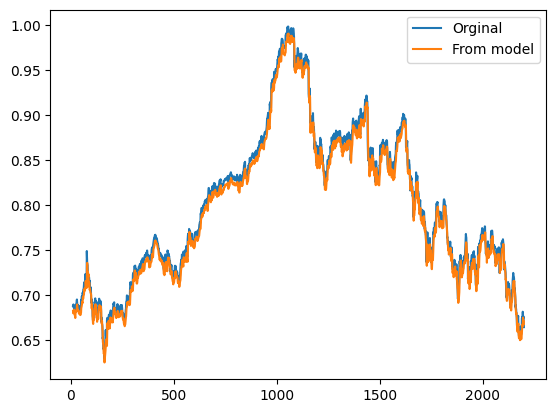

In [ ]:
xaxis = np.linspace(11, 2201, 2192)
yaxis = item1['Close'][10:]
plt.plot(xaxis, yaxis, label='Orginal')
plt.plot(xaxis, ys, label="From model")
plt.legend()